# Trabajo Práctico Número 2: Segmentación

## Autor: Franco Scapolla
## Notebook inicial provista por la cátedra

# 1 Importe de librerías

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D,Conv2DTranspose
from keras.callbacks import EarlyStopping
from keras import metrics
from keras import backend as K
from PIL import Image

# 2 Carga y preprocesamiento de datos

## 2.1 Recuperación de imágenes de train y validación y sus máscaras, y normalización de datos

In [ ]:
#Genero los archivos de train y validación usando la función glob para encontrar en forma recursiva todos los archivos que tienen terminación .tiff en cada carpeta.
train_path = Path("/content/drive/MyDrive/Redes Neuronales/TP2/PhC-C2DH-U373/01").glob("**/*tif")
val_path = Path("/content/drive/MyDrive/Redes Neuronales/TP2/PhC-C2DH-U373/02").glob("**/*tif")

In [ ]:
#Defino dos listas para guardar las imágenes de train y sus correspondientes máscaras
train_images = list()
train_masks = list()
#Cargo cada una de las imágenes de train y su correspondiente máscara
for file in train_path:
    train_images.append(np.array(Image.open(file)).reshape(1,520,696))
    train_masks.append(np.array(Image.open(f'/content/drive/MyDrive/Redes Neuronales/TP2/PhC-C2DH-U373/01_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

#Defino dos listas para guardar las imágenes de validación y sus correspondientes máscaras
val_images = list()
val_masks = list()
#Cargo cada una de las imágenes de validación y sus correspondientes máscaras
for file in val_path:
    val_images.append(np.array(Image.open(file)).reshape(1,520,696))
    val_masks.append(np.array(Image.open(f'/content/drive/MyDrive/Redes Neuronales/TP2/PhC-C2DH-U373/02_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

In [ ]:
#Creo un único array para todas las imágene de train haciendo un stack vertical, y luego normalizo dividiendo por 255
train_images = np.vstack(train_images) / 255.0
train_masks = 1*(np.vstack(train_masks) > 0)
#Creo un único array para todas las imágene de train haciendo un stack vertical, y luego normalizo dividiendo por 255
val_images = np.vstack(val_images) / 255.0
val_masks = 1*(np.vstack(val_masks) >0)

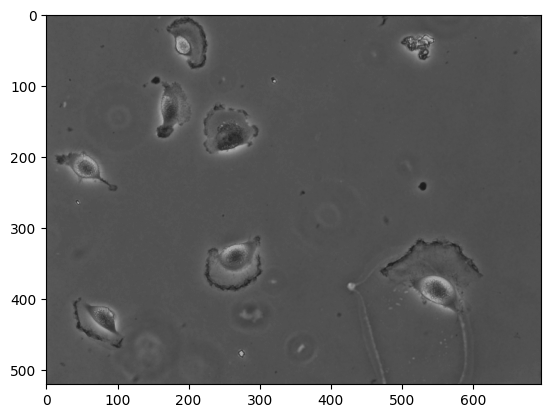

In [ ]:
#Se muestra una imagen con su correspondiente máscara
idx = 100
plt.imshow(train_images[idx], vmin=0, vmax=1, cmap="gray")

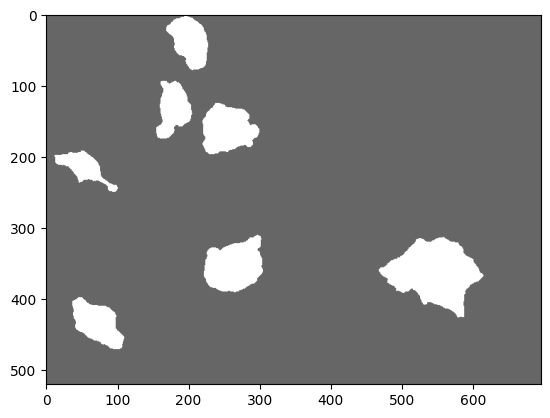

In [ ]:
plt.imshow(train_masks[idx], vmin=0, vmax=1, cmap="gray",alpha=0.6)

## 2.2 Construcción arrays de train y validación con imagen y máscara

Para mantener sincronizada la aumentación entre la imagen y la máscara, armo una entrada de 4 canales que de descompondrán durante el entrenamiento.

In [ ]:
#Armo arrays x_train y x_val, donde cada elemento es una combinación de una imagen con su correspondiente máscara
x_train = np.stack((train_images, train_masks ),axis=-1)
x_val = np.stack((val_images, val_masks ),axis=-1)

In [ ]:
#Shape de x_train y x_val es de la forma (cantidad_de_imágenes, alto, ancho, cantidad_de_canales)
x_train.shape

(115, 520, 696, 2)

In [ ]:
x_val.shape

(115, 520, 696, 2)

In [ ]:
#Verifico que la imagen se encuentre normalizada
x_train[0,:,:,0].max()

0.7254901960784313

In [ ]:
#Verifico la cantidad de imágenes
len(x_train)

115

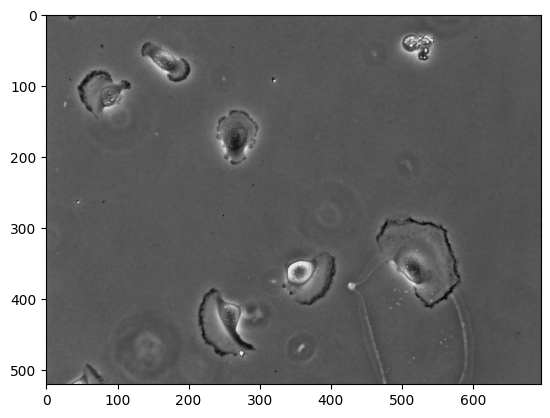

In [ ]:
#Imprimo la primer imagen
plt.imshow(x_train[0,:,:,0], cmap="gray")

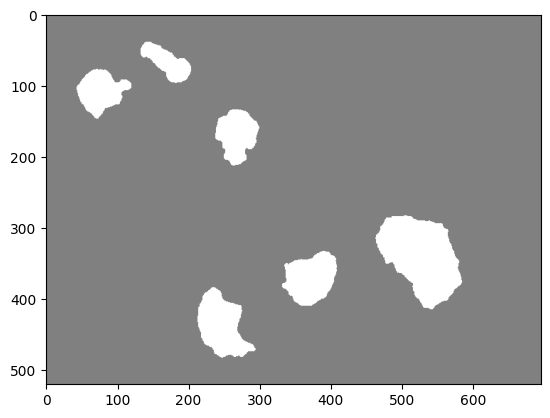

In [ ]:
#Imprimo la máscara correspondiente a la primer imagen
plt.imshow(x_train[0,:,:,1], cmap="gray", alpha = 0.5)

# 2.3 Armado de una red mínima fully convolutional con Atrous Convolutions

In [ ]:
filters = 16
kernel_size = 10
def get_red_seg():
    return Sequential([
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1, input_shape = (None,None,1)),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 2),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 4),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 8),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1),
        tf.keras.layers.Conv2D(1, kernel_size,padding="same", activation = "sigmoid", dilation_rate = 1)
    ])

# 2.4 Armado de la red de preprocesamiento para hacer aumentación

In [ ]:
#Para el aumento de datos considero dos transformaciones: un crop aleatorio a un tamaño de 512x512, y un espejamiento horizontal y vertical
#Luego se exploran otras opciones de data augmentation para mejorar el coeficiente de Dice
def get_preproc():
    return Sequential([
        tf.keras.layers.RandomCrop(512,512),
        tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'),
        #tf.keras.layers.RandomZoom((-0.1,0.3)),
        #tf.keras.layers.RandomTranslation((-0.5, 0.5), (-0.5,0.5)),
        #tf.keras.layers.RandomRotation((0,1)),
        #tf.keras.layers.RandomZoom((0.5,0.5)),
        ])

#La transformación CenterCrop implica hacer un crop centrado de tamaño 512x512
def get_preproc_val():
    return Sequential([
        tf.keras.layers.CenterCrop(512,512),
        ])

In [ ]:
#A modo de ejemplo, aplico las transformaciones definidas arriba a la primer imagen de train y su correspondiente máscara
preproc = get_preproc()
aux_elem = preproc(x_train[0])

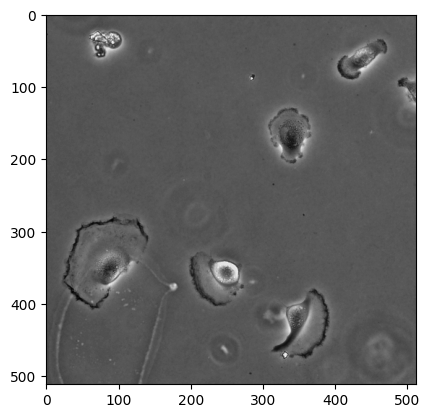

In [ ]:
#La imagen aumentada queda de la siguiente forma
plt.imshow(aux_elem[:,:,0], cmap="gray")

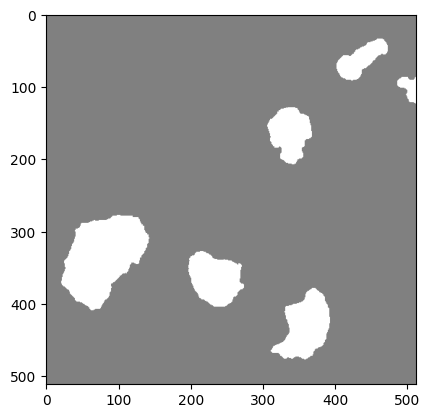

In [ ]:
#La máscara aumentada a su vez queda como se ve a continuación
#Se ve que la máscara efectivamente resulta aumentada junto con la imagen
plt.imshow(aux_elem[:,:,1], cmap="gray", alpha = 0.5)

# 3 Creación del modelo

## 3.1 Definición del coeficiente y pérdida de Dice

In [ ]:
#Defino funciones para calcular el coeficiente y la pérdida de Dice
#El coeficiente mide la similitud entre la máscara predicha y la verdadera en problemas de segmentación binaria
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

## 3.2 Creación de la clase SegmentationModel

Esta clase, que hereda de la clase Model de Keras, permite entrenar y evaluar un modelo de segmentación, con los pasos de preprocesamiento definidos antes, usando la pérdidad de Dice o binary cross-entropy como función de loss.

In [ ]:
class SegmentationModel(Model):
    def __init__(self, red_preproc, red_segmentacion, red_preproc_val):
        super().__init__()
        self.red_segmentacion = red_segmentacion
        self.red_preproc = red_preproc
        self.red_preproc_val = red_preproc_val
        self.loss_tracker = metrics.Mean(name="loss")
        self.dice = False #Indica si usar la pérdida de Dice como función de Loss o usar la binary cross-entropy


    def call(self, inputs):
        #img_mask = self.red_preproc = red_preproc(inputs)
        return self.red_segmentacion(inputs[:,:,:1])

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            data_aug = self.red_preproc(data) #Realizo preprocesamiento
            loss = self._compute_loss(data_aug) #Calculo Loss
            #print(K.mean(loss))

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.red_segmentacion.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.red_segmentacion.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        data_preproc = self.red_preproc_val(data)
        loss = self._compute_loss(data_preproc)
        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        #aux = self.red_preproc(data)
        mask_out = self.red_segmentacion(data[:,:,:,:1])
        #print(mask_out.shape)
        #print(data[:,:,:,1:2].numpy())
        if self.dice == True:
            loss = dice_loss(data[:,:,:,1:2], mask_out)
        else:
            loss = tf.keras.losses.binary_crossentropy(data[:,:,:,1:2], mask_out)
        return loss

    # property
    # def metrics(self):
    #     # We need to list our metrics here so the `reset_states()` can be
    #     # called automatically.
    #     return [self.loss_tracker]

In [ ]:
#red_1 es una red fully convolutional como la que definí arriba
red_1 = get_red_seg()

In [ ]:
red_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 16)    1616      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 1)     1601      
                                                                 
Total params: 105,681
Trainable params: 105,681
Non-trai

In [ ]:
#Creo instancias de los modelos de preprocesamiento
preproc= get_preproc()
preproc_val = get_preproc_val()
#Creo el modelo completo
model = SegmentationModel(preproc, red_1, preproc_val)

In [ ]:
#Compilo el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=dice_loss, metrics=[dice_coef])
#Defino el Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='auto', restore_best_weights=True)

In [ ]:
#Ajusto el modelo
history = model.fit(np.vstack([x_train, x_val]),batch_size=8, epochs=50, validation_split = 0.5, callbacks=[early_stopping], verbose = 1)

Epoch 1/50
15/15 [==============================] - 46s 1s/step - loss: 0.6099 - val_loss: 0.2456
Epoch 2/50
15/15 [==============================] - 8s 569ms/step - loss: 0.3510 - val_loss: 0.2494
Epoch 3/50
15/15 [==============================] - 8s 564ms/step - loss: 0.3385 - val_loss: 0.2037
Epoch 4/50
15/15 [==============================] - 8s 572ms/step - loss: 0.3298 - val_loss: 0.1973
Epoch 5/50
15/15 [==============================] - 9s 577ms/step - loss: 0.3137 - val_loss: 0.1830
Epoch 6/50
15/15 [==============================] - 9s 575ms/step - loss: 0.2848 - val_loss: 0.1483
Epoch 7/50
15/15 [==============================] - 9s 578ms/step - loss: 0.2203 - val_loss: 0.0909
Epoch 8/50
15/15 [==============================] - 9s 579ms/step - loss: 0.1548 - val_loss: 0.0661
Epoch 9/50
15/15 [==============================] - 9s 635ms/step - loss: 0.1250 - val_loss: 0.0610
Epoch 10/50
15/15 [==============================] - 9s 589ms/step - loss: 0.1183 - val_loss: 0.0541
E

Best Validation Dice Coefficient: 0.9659
Best Validation Dice Loss: 0.0341


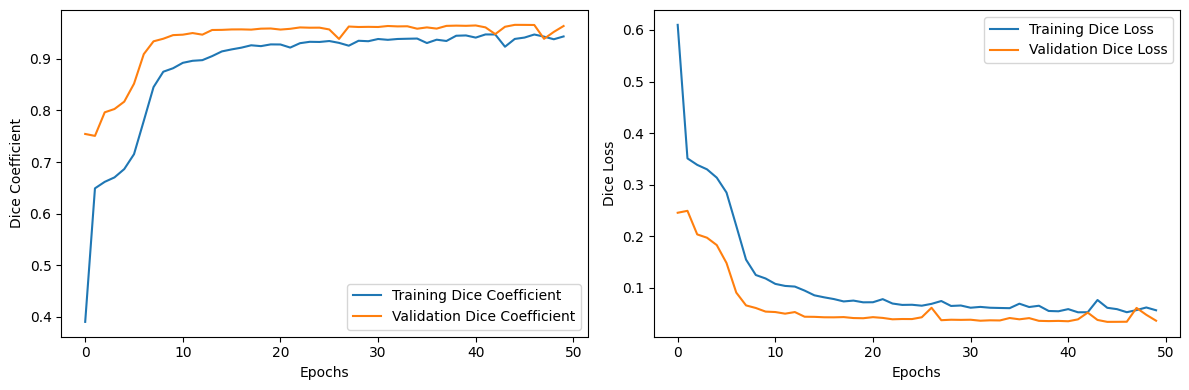

In [ ]:
#Grafico los resultados
print("Best Validation Dice Coefficient: {:.4f}".format(1-min(history.history['val_loss'])))
print("Best Validation Dice Loss: {:.4f}".format(min(history.history['val_loss'])))

loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
dice_coefficients = [1 - loss for loss in loss_values]
val_dice_coefficients = [1 - val_loss for val_loss in val_loss_values]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(dice_coefficients, label='Training Dice Coefficient')
plt.plot(val_dice_coefficients, label='Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Dice Loss')
plt.plot(history.history['val_loss'], label='Validation Dice Loss')
plt.xlabel('Epochs')
plt.ylabel('Dice Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#A modo de ejemplo, hago la predicción con la primera imagen de validación
pred = red_1(x_val[0:1,:,:,0])
pred.shape

TensorShape([1, 520, 696, 1])

In [ ]:
#Verifico que el valor máximo de la predicción esté entre cero y uno
pred.numpy().max()

0.9969126

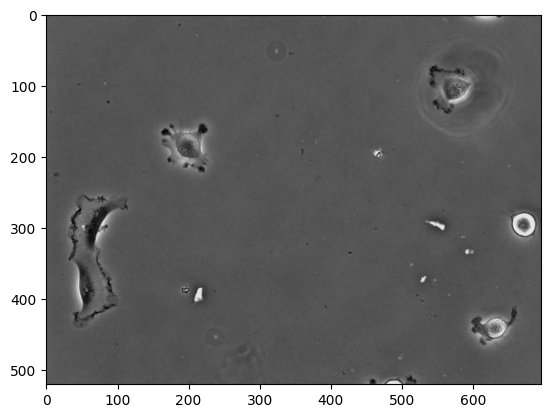

In [ ]:
#Imprimo la primera imagen, la que se usó para la  predicción
plt.imshow(x_val[0,:,:,0], cmap="gray")

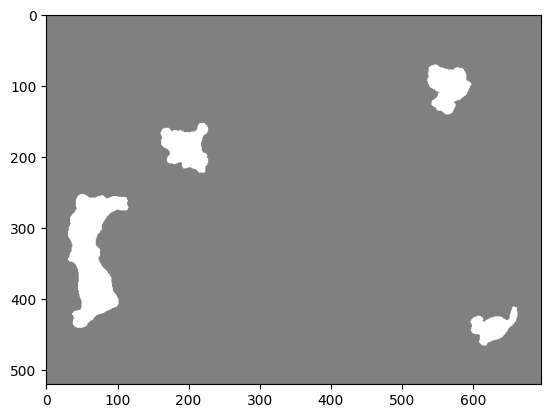

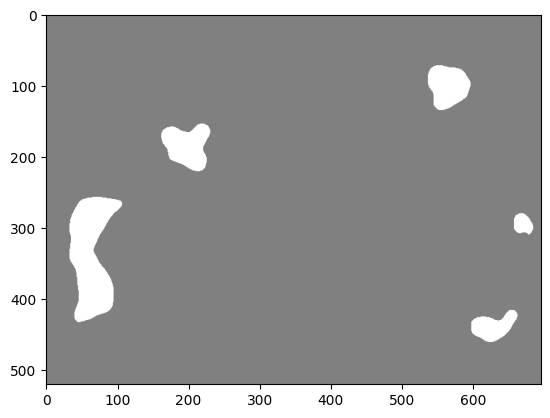

In [ ]:
#Imprimo la máscara de la primera imagen de validación y la máscara predicha
plt.imshow(x_val[0,:,:,1], cmap="gray", alpha=0.5)
plt.show()
plt.imshow(pred[0,:,:,0]>0.5, cmap="gray", alpha=0.5)
plt.show()

# 4 Segmentación con una arquitectura U-Net

La U-Net es una arquitectura convolucional creada por Olaf Ronneberger, Philipp Fischer y Thomas Brox en 2015, y desarrollada originalmente para la segmentación de imágenes biomédicas (link al paper original: https://arxiv.org/abs/1505.04597). Una imagen de la arquitectura original tomada del paper se presenta a continuación:

![picture](https://drive.google.com/uc?export=view&id=1m2EjeoXFHe5qK2BzMoJXhM8fFVUiraMB)

La U-Net recibe su nombre por la forma de U que tiene. La misma se divide en dos partes: una parte de enconder (los primeros cuatro bloques), y otra de decoder (los últimos cuatro). Cada bloque de la parte de encoder reduce la cantidad de información espacial y aumenta la información de features, a través del uso de operaciones de max pooling. Cada bloque de decoder hace lo contrario, haciendo upsampling para aumentar la cantidad de información espacial y reducir la cantidad de información de features.

Las conexiones residuales se refieren a las conexiones que conectan directamente bloques de la etapa de encoder con bloques de la etapa de decoder. La idea es que estas conexiones permiten intercambiar información entre etapas que ayude a generar mejores features semánticas y, además, reducir el problema de vanishing gradient al utilizar backpropagation.

Una descripción básicas de las distintas funciones de esta implementación:

conv_block representa un bloque que consta de dos redes convolucionales (Conv2D). Hay capas de BatchNormalization y de Dropout que son opcionales.
Hiperparámetros de las redes convolucionales:
* dim = cantidad de filtros
* padding, en este caso fijo en 'same'
* activation = función de activación
* kernel_size, en este caso fijo en 3, es decir de tamaño 3 en todas dimensiones

'do' representa el dropout rate, 'bn' es un flag para indicar si incluir o no Batch Normalization, y 'res' es un flag para indicar si incluir o no conexiones residuales.

level_block define un nivel de la arquitectura de U-Net. 'depth' es la cantidad de niveles hacia abajo restantes (dado que la funcion se llama recursivamente), 'inc' es un flag para indicar en cuánto aumenta la cantidad de filtros por cada nivel que se desciende, 'mp' es un flag para indicar si usar max pooling o strided convolution para realizar el downsampling, 'up' es un flag que indica si usar upsampling o transposed convolution para el upsampling. Esta función crea la U-Net recursivamente...

In [ ]:
img_shape = (512, 512, 1)
def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu',
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

In [ ]:
#Usando la U-Net definida arriba junto con las transformaciones de preprocesamiento
#se crea un modelo para segmentación basado en U-Net
preproc_unet= get_preproc()
preproc_unet_val= get_preproc_val()
red_unet = UNet(
    img_shape,
    start_ch = 16,
    dropout = False,
    residual = True
)
model_unet = SegmentationModel(preproc_unet, red_unet,preproc_unet_val)

In [ ]:
#Compilo el modelo
model_unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=dice_loss, metrics=[dice_coef])
#Defino el Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='auto', restore_best_weights=True)

In [ ]:
history = model_unet.fit(np.vstack([x_train, x_val]),batch_size=8, epochs=50, validation_split = 0.5, callbacks=[early_stopping], verbose = 1)

Epoch 1/50
15/15 [==============================] - 22s 878ms/step - loss: 0.5102 - val_loss: 0.2493
Epoch 2/50
15/15 [==============================] - 11s 770ms/step - loss: 0.3539 - val_loss: 0.2353
Epoch 3/50
15/15 [==============================] - 12s 779ms/step - loss: 0.3418 - val_loss: 0.2183
Epoch 4/50
15/15 [==============================] - 12s 784ms/step - loss: 0.3335 - val_loss: 0.2012
Epoch 5/50
15/15 [==============================] - 12s 785ms/step - loss: 0.3147 - val_loss: 0.1725
Epoch 6/50
15/15 [==============================] - 12s 792ms/step - loss: 0.2283 - val_loss: 0.0846
Epoch 7/50
15/15 [==============================] - 12s 795ms/step - loss: 0.1561 - val_loss: 0.0933
Epoch 8/50
15/15 [==============================] - 14s 978ms/step - loss: 0.1619 - val_loss: 0.0981
Epoch 9/50
15/15 [==============================] - 12s 806ms/step - loss: 0.1299 - val_loss: 0.0603
Epoch 10/50
15/15 [==============================] - 14s 985ms/step - loss: 0.1153 - val_lo

Best Validation Dice Coefficient: 0.9742
Best Validation Dice Loss: 0.0258


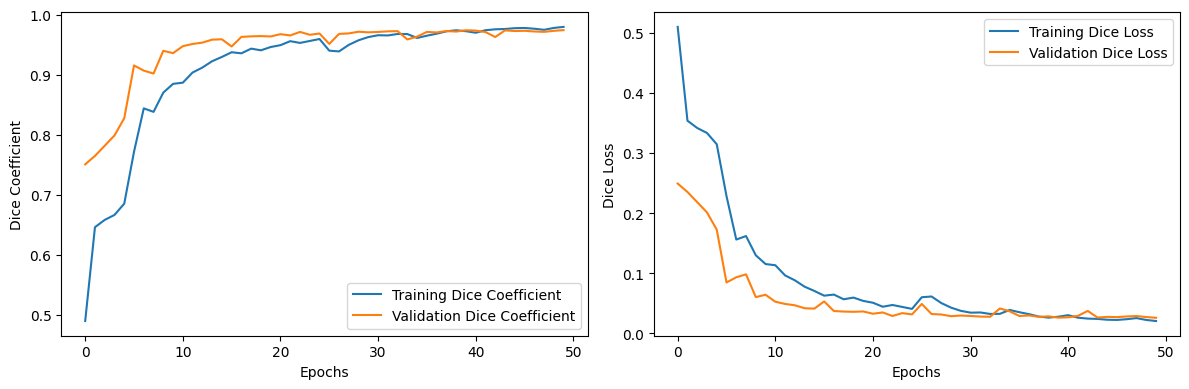

In [ ]:
#Grafico los resultados
print("Best Validation Dice Coefficient: {:.4f}".format(1-min(history.history['val_loss'])))
print("Best Validation Dice Loss: {:.4f}".format(min(history.history['val_loss'])))

loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
dice_coefficients = [1 - loss for loss in loss_values]
val_dice_coefficients = [1 - val_loss for val_loss in val_loss_values]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(dice_coefficients, label='Training Dice Coefficient')
plt.plot(val_dice_coefficients, label='Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Dice Loss')
plt.plot(history.history['val_loss'], label='Validation Dice Loss')
plt.xlabel('Epochs')
plt.ylabel('Dice Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
red_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
aux = preproc_unet_val(x_val[0:1,:,:,:])
pred = red_unet(aux[0:1,:,:,0])
pred.shape

TensorShape([1, 512, 512, 1])

In [ ]:
pred.numpy().max()

0.99954563

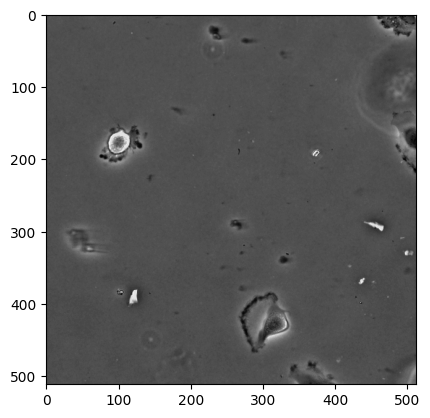

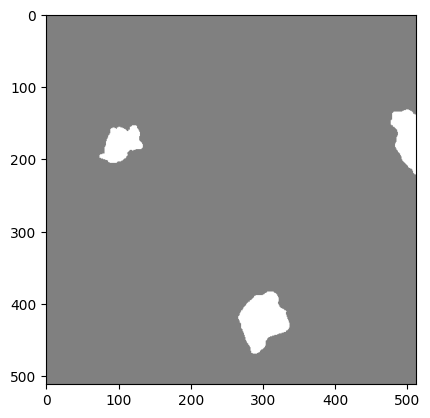

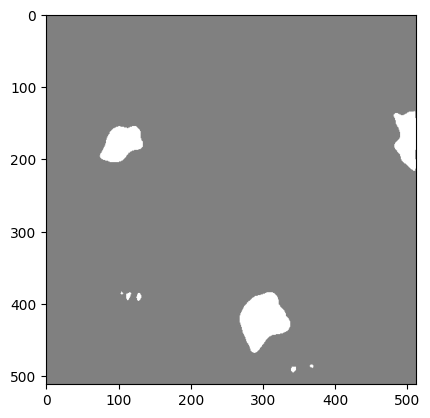

In [ ]:
# A modo de ejemplo, comparo la máscara original con la predicha
plt.imshow(aux[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(aux[0,:,:,1], cmap="gray", alpha = 0.5)
plt.show()
plt.imshow(pred[0,:,:,0]>0.7, cmap="gray", alpha = 0.5)
plt.show()

# 5 Mejoras sobre la red

El objetivo es lograr aumentar el coeficiente de Dice mayor cambiando alguno de los parámetros de la arquitectura de la U-Net. Se parte de un modelo de referencia, que es el que se entrenó arriba (sin dropout, sin batch normalization, con una cantidad inicial de filtros de 16 y una profundidad de 4) y se prueba por separado cómo cambiar los distintos parámetros afecta al coeficiente de Dice.

## 5.1 Cambio en el coeficiente de Dice al agregar transformaciones de datos

Lo primero que se ensaya es agregar más transformaciones para el aumento de datos. Para esta primer prueba, el resto de los parámetros se deja constante para tener un modelo de referencia. Si bien lo recomendable es primero entrenar con binary cross-entropy y luego pasar a dice loss, como el dataset con el que se está trabajando es sencillo, y por una cuestión de tiempo y de acceso a recursos, se entrena con el dice loss directamente.

In [ ]:
#Agrego más transformaciones para el aumento de datos
def get_preproc():
    return Sequential([
        tf.keras.layers.RandomCrop(512,512),
        tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'),
        tf.keras.layers.RandomTranslation((-0.5, 0.5), (-0.5,0.5)),
        tf.keras.layers.RandomRotation((0,1)),
        tf.keras.layers.RandomZoom((0.5,0.5)),
        ])

#La transformación CenterCrop implica hacer un crop centrado de tamaño 512x512
def get_preproc_val():
    return Sequential([
        tf.keras.layers.CenterCrop(512,512),
        ])

In [ ]:
#Uso los mismos parámetros para la U-Net que antes
preproc_unet= get_preproc()
preproc_unet_val= get_preproc_val()
red_unet = UNet(
    img_shape,
    start_ch = 16,
    dropout = False,
    residual = True
)
model = SegmentationModel(preproc_unet, red_unet,preproc_unet_val)

In [ ]:
#Compilo el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=dice_loss, metrics=[dice_coef])
#Defino el Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='auto', restore_best_weights=True)

In [ ]:
#Ajusto el modelo
history = model.fit(np.vstack([x_train, x_val]),batch_size=8, epochs=50, validation_split = 0.5, callbacks=[early_stopping], verbose = 1)

Epoch 1/50
15/15 [==============================] - 42s 1s/step - loss: 0.6209 - val_loss: 0.4929
Epoch 2/50
15/15 [==============================] - 12s 789ms/step - loss: 0.3927 - val_loss: 0.2333
Epoch 3/50
15/15 [==============================] - 12s 794ms/step - loss: 0.3622 - val_loss: 0.1930
Epoch 4/50
15/15 [==============================] - 12s 793ms/step - loss: 0.3426 - val_loss: 0.2121
Epoch 5/50
15/15 [==============================] - 14s 982ms/step - loss: 0.3348 - val_loss: 0.2097
Epoch 6/50
15/15 [==============================] - 12s 807ms/step - loss: 0.3178 - val_loss: 0.1689
Epoch 7/50
15/15 [==============================] - 12s 812ms/step - loss: 0.3009 - val_loss: 0.1135
Epoch 8/50
15/15 [==============================] - 15s 994ms/step - loss: 0.2120 - val_loss: 0.0668
Epoch 9/50
15/15 [==============================] - 15s 995ms/step - loss: 0.1603 - val_loss: 0.0729
Epoch 10/50
15/15 [==============================] - 15s 998ms/step - loss: 0.1572 - val_loss:

Best Validation Dice Coefficient: 0.9706
Best Validation Dice Loss: 0.0294


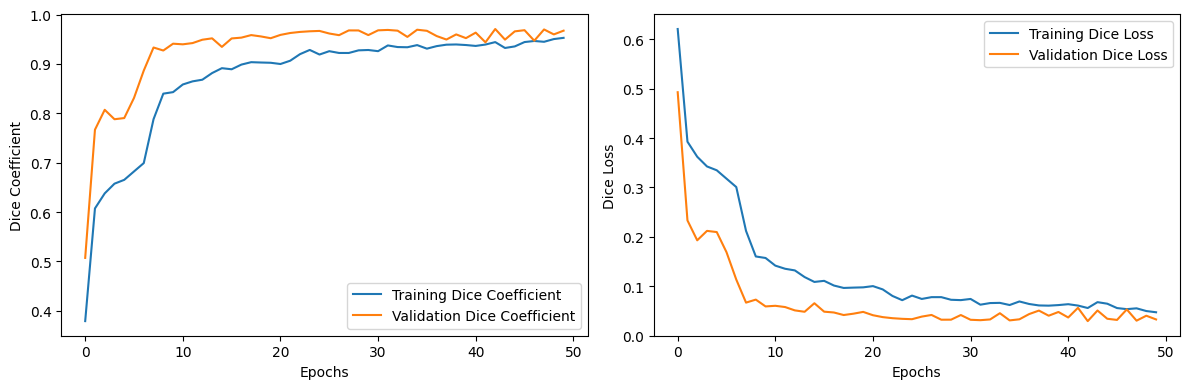

In [ ]:
#Grafico los resultados
print("Best Validation Dice Coefficient: {:.4f}".format(1-min(history.history['val_loss'])))
print("Best Validation Dice Loss: {:.4f}".format(min(history.history['val_loss'])))

loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
dice_coefficients = [1 - loss for loss in loss_values]
val_dice_coefficients = [1 - val_loss for val_loss in val_loss_values]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(dice_coefficients, label='Training Dice Coefficient')
plt.plot(val_dice_coefficients, label='Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Dice Loss')
plt.plot(history.history['val_loss'], label='Validation Dice Loss')
plt.xlabel('Epochs')
plt.ylabel('Dice Loss')
plt.legend()

plt.tight_layout()
plt.show()

No se observa una mejora apreciable con respecto al caso anterior. Se corrió el modelo varias veces y en algunos casos los resultados fueron peores que al no aplicar las transformaciones adicionales. Se consideró que puediera tratarse de un problema de over-augmentation, en donde el exceso de transformaciones distorsiona los datos causando un desempeño peor. Sin embargo, como las variaciones, tanto positivas como negativas, resultaron tan insignificantes, no se analizó en más detalle.

## 5.2 Cambio en el coeficiente de Dice al introducir Dropout

Ahora se introduce dropout al modelo con el objetivo, nuevamente, de aumentar el coeficiente de Dice. Por una cuestión de tiempo y recursos, se analizan sólo dos valores de dropout rate: 0.2 y 0.5

In [ ]:
#Pruebo con dos valores
dropout_rates = [0.2, 0.5]
dropout_values = ["0.2", "0.5"]
losses = []

In [ ]:
for dropout in dropout_rates:
  preproc_unet= get_preproc()
  preproc_unet_val= get_preproc_val()
  red_unet = UNet(
    img_shape,
    start_ch = 16,
    dropout = dropout,
    residual = True
  )
  model = SegmentationModel(preproc_unet, red_unet,preproc_unet_val)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=dice_loss, metrics=[dice_coef])
  early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='auto', restore_best_weights=True)
  history = model.fit(np.vstack([x_train, x_val]),batch_size=8, epochs=50, validation_split = 0.5, callbacks=[early_stopping], verbose = 1)
  losses.append(history.history['val_loss'])

Epoch 1/50
15/15 [==============================] - 51s 1s/step - loss: 0.6255 - val_loss: 0.5003
Epoch 2/50
15/15 [==============================] - 11s 754ms/step - loss: 0.4097 - val_loss: 0.2556
Epoch 3/50
15/15 [==============================] - 11s 763ms/step - loss: 0.3602 - val_loss: 0.2072
Epoch 4/50
15/15 [==============================] - 12s 780ms/step - loss: 0.3499 - val_loss: 0.2100
Epoch 5/50
15/15 [==============================] - 12s 781ms/step - loss: 0.3298 - val_loss: 0.1877
Epoch 6/50
15/15 [==============================] - 12s 784ms/step - loss: 0.3019 - val_loss: 0.1471
Epoch 7/50
15/15 [==============================] - 12s 791ms/step - loss: 0.2107 - val_loss: 0.1199
Epoch 8/50
15/15 [==============================] - 12s 797ms/step - loss: 0.1605 - val_loss: 0.0915
Epoch 9/50
15/15 [==============================] - 12s 809ms/step - loss: 0.1388 - val_loss: 0.0676
Epoch 10/50
15/15 [==============================] - 12s 815ms/step - loss: 0.1272 - val_loss:

for Dropout Rate: 0.2, Highest Validation Dice Coefficient: 0.9734499510377645
for Dropout Rate: 0.2, Lowest Validation Dice Loss: 0.02655004896223545
for Dropout Rate: 0.5, Highest Validation Dice Coefficient: 0.975378280505538
for Dropout Rate: 0.5, Lowest Validation Dice Loss: 0.024621719494462013


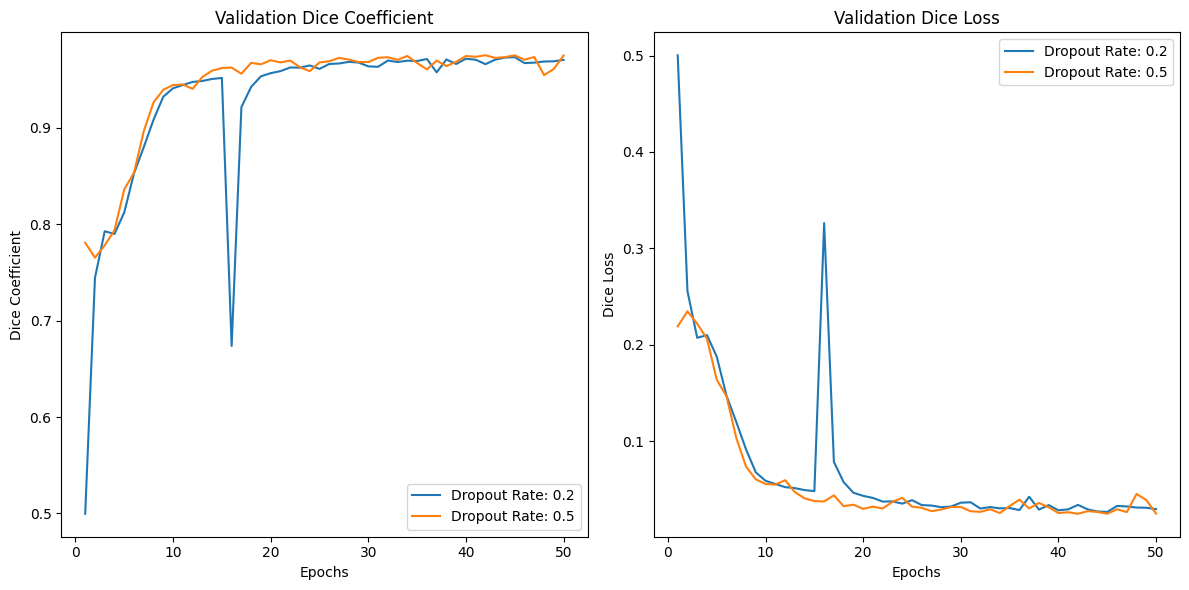

In [ ]:
#Grafico los resultados
for dropout_rate, dice_loss in zip(dropout_rates, losses):
    min_dice_loss = min(dice_loss)
    print(f"for Dropout Rate: {dropout_rate}, Highest Validation Dice Coefficient: {1-min_dice_loss}")
    print(f"for Dropout Rate: {dropout_rate}, Lowest Validation Dice Loss: {min_dice_loss}")

epochs = range(1, len(losses[0]) + 1)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for dropout_rate, loss_values in zip(dropout_rates, losses):
    modified_loss_values = [1 - loss for loss in loss_values]
    axes[0].plot(epochs, modified_loss_values, label=f"Dropout Rate: {dropout_rate}")

axes[0].set_title("Validation Dice Coefficient")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Dice Coefficient")
axes[0].legend()

for dropout_rate, loss_values in zip(dropout_rates, losses):
    axes[1].plot(epochs, loss_values, label=f"Dropout Rate: {dropout_rate}")

axes[1].set_title("Validation Dice Loss")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Dice Loss")
axes[1].legend()

plt.tight_layout()
plt.show()

En ambos casos se obtiene una mejora frente al caso sin dropout, aunque la misma no es muy significativa. En particular, con dropout rate de 0.5 se obtienen resultados ligeramente mejores. Se observa que en algún epoch entre el 10 y el 20 el coeficiente de Dice con un rate de 0.2 experimenta una caída abrupta, cuya causa no se pudo explicar, pero luego vuelve a valores similares al del rate de 0.5.

## 5.3 Cambio en el coeficiente de Dice al introducir Batch Normalization

Se agrega al modelo de U-Net Batch Normalization. Se quita el dropout ya que en general se considera que tener ambos a la vez tiene peores resultados que tener cada uno por separado

In [ ]:
#Creo la red
preproc_unet= get_preproc()
preproc_unet_val= get_preproc_val()
red_unet = UNet(
    img_shape,
    start_ch = 16,
    dropout = False,
    batchnorm = True,
    residual = True
)
model = SegmentationModel(preproc_unet, red_unet,preproc_unet_val)

In [ ]:
#Compilo el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=dice_loss, metrics=[dice_coef])
#Defino el Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='auto', restore_best_weights=True)

In [ ]:
#Ajusto el modelo
history = model.fit(np.vstack([x_train, x_val]),batch_size=8, epochs=50, validation_split = 0.5, callbacks=[early_stopping], verbose = 1)

Epoch 1/50
15/15 [==============================] - 60s 1s/step - loss: 0.6763 - val_loss: 0.5462
Epoch 2/50
15/15 [==============================] - 15s 1s/step - loss: 0.4192 - val_loss: 0.2440
Epoch 3/50
15/15 [==============================] - 15s 1s/step - loss: 0.3586 - val_loss: 0.2054
Epoch 4/50
15/15 [==============================] - 15s 1s/step - loss: 0.3405 - val_loss: 0.1959
Epoch 5/50
15/15 [==============================] - 15s 1s/step - loss: 0.3316 - val_loss: 0.1929
Epoch 6/50
15/15 [==============================] - 13s 862ms/step - loss: 0.3221 - val_loss: 0.1772
Epoch 7/50
15/15 [==============================] - 13s 869ms/step - loss: 0.2679 - val_loss: 0.1911
Epoch 8/50
15/15 [==============================] - 15s 1s/step - loss: 0.1876 - val_loss: 0.0913
Epoch 9/50
15/15 [==============================] - 13s 865ms/step - loss: 0.1460 - val_loss: 0.0672
Epoch 10/50
15/15 [==============================] - 13s 864ms/step - loss: 0.1249 - val_loss: 0.0660
Epoch 1

Best Validation Dice Coefficient: 0.9708
Best Validation Dice Loss: 0.0292


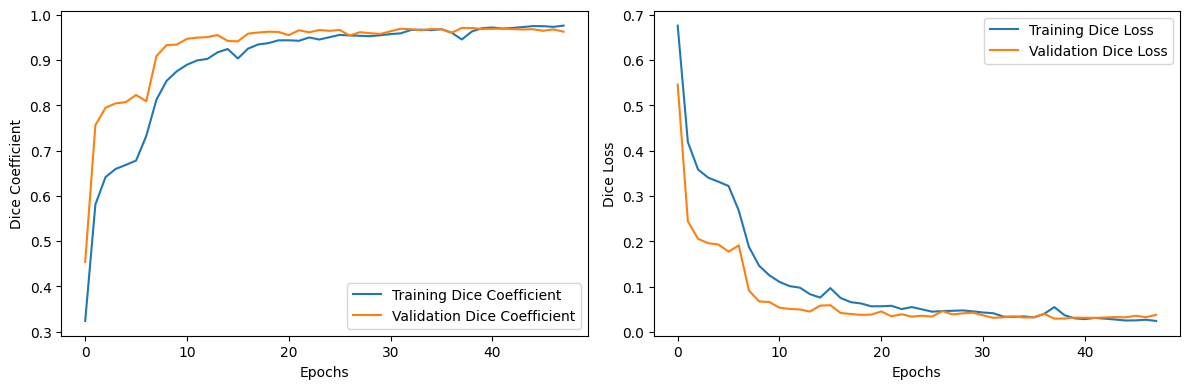

In [ ]:
#Grafico los resultados
print("Best Validation Dice Coefficient: {:.4f}".format(1-min(history.history['val_loss'])))
print("Best Validation Dice Loss: {:.4f}".format(min(history.history['val_loss'])))

loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
dice_coefficients = [1 - loss for loss in loss_values]
val_dice_coefficients = [1 - val_loss for val_loss in val_loss_values]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(dice_coefficients, label='Training Dice Coefficient')
plt.plot(val_dice_coefficients, label='Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Dice Loss')
plt.plot(history.history['val_loss'], label='Validation Dice Loss')
plt.xlabel('Epochs')
plt.ylabel('Dice Loss')
plt.legend()

plt.tight_layout()
plt.show()

Nuevamente, si bien se aprecia un aumento frente al caso de referencia, el mismo no es muy significativo. Además, es menor que para el caso con dropout.

## 5.4 Cambio en el coeficiente de Dice al cambiar la cantidad inicial de filtros

El parámetro start_ch controla la cantidad de filtros en la primer capa del modelo. Mientras mayor sea este número, el modelo podrá, en principio, captar detalles más finos (ya que en cada etapa del encoder la cantidad de filtros aumenta), pero la complejidad del modelo y los requisitos de computacionales para entrenar serán mayores. Por una cuestión de tiempo y acceso a recursos, se analiza únicamente tres cantidades iniciales de filtros: 16, 20, y 24.

In [ ]:
#Pruebo con tres valores
initial_filters = [16, 20, 24]
initial_filters_values = ["16", "20", "24"]
losses = []

In [ ]:
for initial_filter in initial_filters:
  preproc_unet= get_preproc()
  preproc_unet_val= get_preproc_val()
  red_unet = UNet(
    img_shape,
    start_ch = initial_filter,
    dropout = False,
    residual = True
  )
  model = SegmentationModel(preproc_unet, red_unet,preproc_unet_val)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=dice_loss, metrics=[dice_coef])
  early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='auto', restore_best_weights=True)
  history = model.fit(np.vstack([x_train, x_val]),batch_size=8, epochs=50, validation_split = 0.5, callbacks=[early_stopping], verbose = 1)
  losses.append(history.history['val_loss'])

Epoch 1/50
15/15 [==============================] - 49s 1s/step - loss: 0.6450 - val_loss: 0.4114
Epoch 2/50
15/15 [==============================] - 14s 966ms/step - loss: 0.3834 - val_loss: 0.2838
Epoch 3/50
15/15 [==============================] - 14s 975ms/step - loss: 0.3593 - val_loss: 0.2277
Epoch 4/50
15/15 [==============================] - 12s 804ms/step - loss: 0.3466 - val_loss: 0.2108
Epoch 5/50
15/15 [==============================] - 12s 817ms/step - loss: 0.3349 - val_loss: 0.1946
Epoch 6/50
15/15 [==============================] - 12s 824ms/step - loss: 0.3153 - val_loss: 0.2015
Epoch 7/50
15/15 [==============================] - 12s 813ms/step - loss: 0.2489 - val_loss: 0.1443
Epoch 8/50
15/15 [==============================] - 12s 806ms/step - loss: 0.1628 - val_loss: 0.0642
Epoch 9/50
15/15 [==============================] - 12s 805ms/step - loss: 0.1298 - val_loss: 0.0649
Epoch 10/50
15/15 [==============================] - 12s 806ms/step - loss: 0.1127 - val_loss:

for 16 starting channels, Highest Validation Dice Coefficient: 0.9769145902246237
for 16 starting channels, Lowest Validation Dice Loss: 0.02308540977537632
for 20 starting channels, Highest Validation Dice Coefficient: 0.9768415745347738
for 20 starting channels, Lowest Validation Dice Loss: 0.023158425465226173
for 24 starting channels, Highest Validation Dice Coefficient: 0.977147875353694
for 24 starting channels, Lowest Validation Dice Loss: 0.022852124646306038


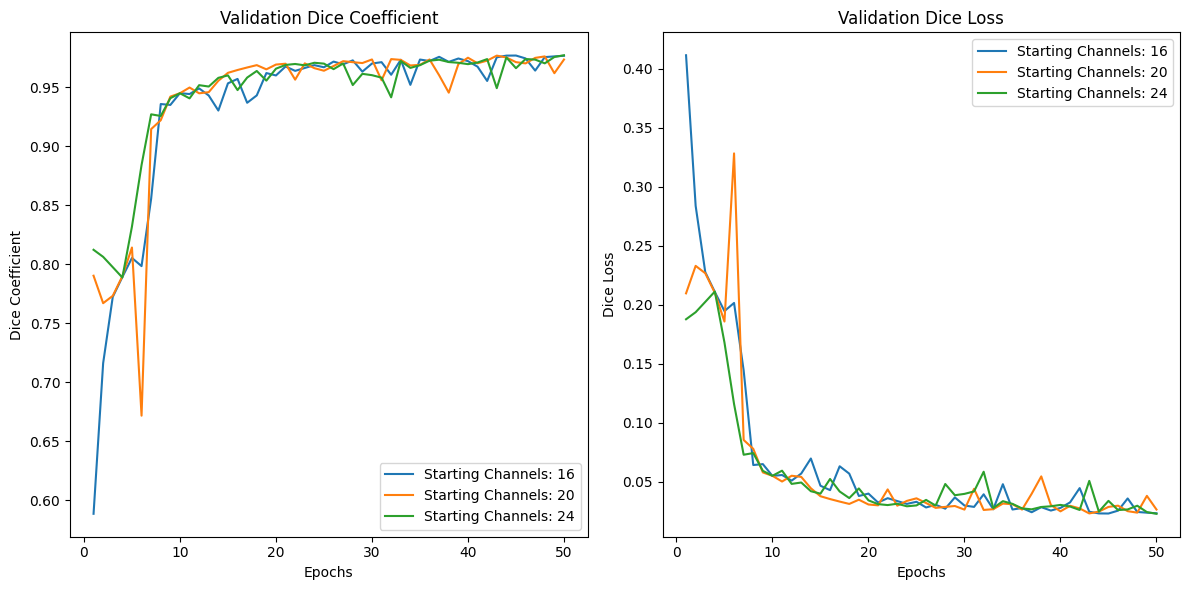

In [ ]:
#Grafico los resultados
for initial_filter, dice_loss in zip(initial_filters, losses):
    min_dice_loss = min(dice_loss)
    print(f"for {initial_filter} starting channels, Highest Validation Dice Coefficient: {1-min_dice_loss}")
    print(f"for {initial_filter} starting channels, Lowest Validation Dice Loss: {min_dice_loss}")

epochs = range(1, len(losses[0]) + 1)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for initial_filter, loss_values in zip(initial_filters, losses):
    modified_loss_values = [1 - loss for loss in loss_values]
    axes[0].plot(epochs, modified_loss_values, label=f"Starting Channels: {initial_filter}")

axes[0].set_title("Validation Dice Coefficient")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Dice Coefficient")
axes[0].legend()

for initial_filter, loss_values in zip(initial_filters, losses):
    axes[1].plot(epochs, loss_values, label=f"Starting Channels: {initial_filter}")

axes[1].set_title("Validation Dice Loss")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Dice Loss")
axes[1].legend()

plt.tight_layout()
plt.show()

Se observa que en los tres casos los resultados obtenidos son muy similares, siendo el valor más alto como se esperaba el que tiene 24 filtros en la primera etapa. Sin embargo, curiosamente, el modelo con 16 filtros da un resultado apenas superior al de 20. Es posible que los valores ensayados estén demasiado cerca uno de los otros para arrojar diferencias significativas en este problema con estos parámetros. Se intentó entrenar modelos con cantidades iniciales de 32 y superiores pero la memoria RAM ofrecida por Colab no resultó suficiente.

## 5.5 Cambio en el coeficiente de Dice al cambiar el increment rate

Ahora se analiza cómo variar el increment/increase rate afecta al rendimiento del modelo. Se vuelve al caso con 16 filtros en la primer etapa. En este caso el increment rate se refiere a la tasa en la que se incrementan los canales en cada bloque de la etapa de decoder. Mientras mayor es este número, en principio, mayor es la habilidad del modelo de capturar detalles complejos.

In [ ]:
#Pruebo con dos valores
increase_rates = [2, 3]
increase_rates_values = ["2", "3"]
losses = []

In [ ]:
for increase_rate in increase_rates:
  preproc_unet= get_preproc()
  preproc_unet_val= get_preproc_val()
  red_unet = UNet(
    img_shape,
    start_ch = 16,
    inc_rate = increase_rate,
    dropout = False,
    residual = True
  )
  model = SegmentationModel(preproc_unet, red_unet,preproc_unet_val)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=dice_loss, metrics=[dice_coef])
  early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='auto', restore_best_weights=True)
  history = model.fit(np.vstack([x_train, x_val]),batch_size=8, epochs=50, validation_split = 0.5, callbacks=[early_stopping], verbose = 1)
  losses.append(history.history['val_loss'])

Epoch 1/50
15/15 [==============================] - 50s 1s/step - loss: 0.6745 - val_loss: 0.5573
Epoch 2/50
15/15 [==============================] - 11s 753ms/step - loss: 0.4210 - val_loss: 0.2513
Epoch 3/50
15/15 [==============================] - 11s 764ms/step - loss: 0.3618 - val_loss: 0.2170
Epoch 4/50
15/15 [==============================] - 11s 771ms/step - loss: 0.3465 - val_loss: 0.2123
Epoch 5/50
15/15 [==============================] - 11s 770ms/step - loss: 0.3329 - val_loss: 0.1974
Epoch 6/50
15/15 [==============================] - 12s 783ms/step - loss: 0.3102 - val_loss: 0.1540
Epoch 7/50
15/15 [==============================] - 12s 783ms/step - loss: 0.2671 - val_loss: 0.1029
Epoch 8/50
15/15 [==============================] - 12s 788ms/step - loss: 0.1689 - val_loss: 0.0854
Epoch 9/50
15/15 [==============================] - 12s 796ms/step - loss: 0.1335 - val_loss: 0.0588
Epoch 10/50
15/15 [==============================] - 14s 981ms/step - loss: 0.1156 - val_loss:

for Increase Rate: 2, Highest Validation Dice Coefficient: 0.9755281172692776
for Increase Rate: 2, Lowest Validation Dice Loss: 0.024471882730722427
for Increase Rate: 3, Highest Validation Dice Coefficient: 0.9824958089739084
for Increase Rate: 3, Lowest Validation Dice Loss: 0.017504191026091576


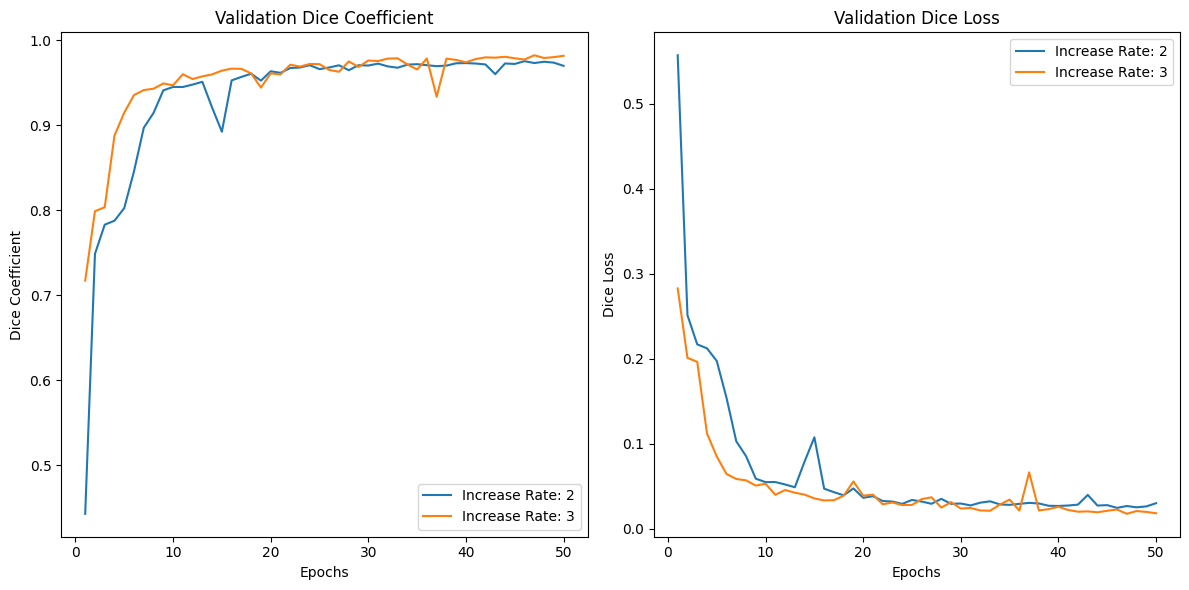

In [ ]:
#Grafico los resultados
for increase_rate, dice_loss in zip(increase_rates, losses):
    min_dice_loss = min(dice_loss)
    print(f"for Increase Rate: {increase_rate}, Highest Validation Dice Coefficient: {1-min_dice_loss}")
    print(f"for Increase Rate: {increase_rate}, Lowest Validation Dice Loss: {min_dice_loss}")

epochs = range(1, len(losses[0]) + 1)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for increase_rate, loss_values in zip(increase_rates, losses):
    modified_loss_values = [1 - loss for loss in loss_values]
    axes[0].plot(epochs, modified_loss_values, label=f"Increase Rate: {increase_rate}")

axes[0].set_title("Validation Dice Coefficient")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Dice Coefficient")
axes[0].legend()

for increase_rate, loss_values in zip(increase_rates, losses):
    axes[1].plot(epochs, loss_values, label=f"Increase Rate: {increase_rate}")

axes[1].set_title("Validation Dice Loss")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Dice Loss")
axes[1].legend()

plt.tight_layout()
plt.show()

Se observa que, tal como se esperaba, el mayor valor de increment rate resulta en un desempeño mejor del modelo, si bien las diferencias no son muy significativas. Se intentó también entrenar con un increment rate de 4 pero la memoria RAM ofrecida por Colab no resultó suficiente.

## 5.6 Cambio en el coeficiente de Dice al variar la profundidad de la red

Se analiza cómo cambia el coeficiente de Dice al aumentar la profundidad de la red. Esto se controla con la variable depth. En un principio, mientras mayor sea la profundidad, mayor será el detalle que el modelo pueda capturar. Sin embargo, los requisitos computacionales también aumentan.

In [ ]:
#Pruebo con tres valores
depths = [3, 4, 5]
depth_values = ["3", "4", "5"]
losses = []

In [ ]:
for depth in depths:
  preproc_unet= get_preproc()
  preproc_unet_val= get_preproc_val()
  red_unet = UNet(
    img_shape,
    start_ch = 16,
    depth = depth,
    dropout = False,
    residual = True
  )
  model = SegmentationModel(preproc_unet, red_unet,preproc_unet_val)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=dice_loss, metrics=[dice_coef])
  early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='auto', restore_best_weights=True)
  history = model.fit(np.vstack([x_train, x_val]),batch_size=8, epochs=50, validation_split = 0.5, callbacks=[early_stopping], verbose = 1)
  losses.append(history.history['val_loss'])

Epoch 1/50
15/15 [==============================] - 43s 1s/step - loss: 0.6066 - val_loss: 0.5393
Epoch 2/50
15/15 [==============================] - 10s 665ms/step - loss: 0.4771 - val_loss: 0.2314
Epoch 3/50
15/15 [==============================] - 10s 672ms/step - loss: 0.3481 - val_loss: 0.2371
Epoch 4/50
15/15 [==============================] - 10s 681ms/step - loss: 0.3454 - val_loss: 0.1990
Epoch 5/50
15/15 [==============================] - 10s 693ms/step - loss: 0.3333 - val_loss: 0.2009
Epoch 6/50
15/15 [==============================] - 10s 700ms/step - loss: 0.3288 - val_loss: 0.1950
Epoch 7/50
15/15 [==============================] - 11s 735ms/step - loss: 0.3037 - val_loss: 0.1645
Epoch 8/50
15/15 [==============================] - 11s 723ms/step - loss: 0.2155 - val_loss: 0.0778
Epoch 9/50
15/15 [==============================] - 11s 728ms/step - loss: 0.1374 - val_loss: 0.0577
Epoch 10/50
15/15 [==============================] - 11s 721ms/step - loss: 0.1113 - val_loss:

for Depth: 3, Highest Validation Dice Coefficient: 0.9716578926891088
for Depth: 3, Lowest Validation Dice Loss: 0.02834210731089115
for Depth: 4, Highest Validation Dice Coefficient: 0.9736239574849606
for Depth: 4, Lowest Validation Dice Loss: 0.026376042515039444
for Depth: 5, Highest Validation Dice Coefficient: 0.9809215366840363
for Depth: 5, Lowest Validation Dice Loss: 0.019078463315963745


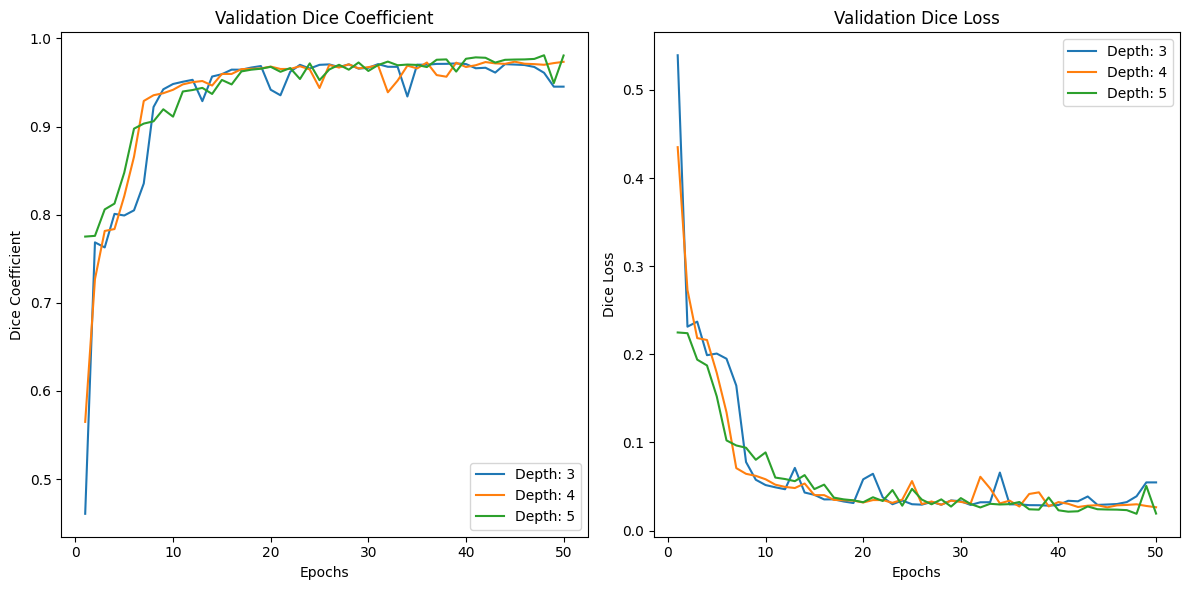

In [ ]:
#Grafico los resultados
losses[0].append(losses[0][48])

for depth, dice_loss in zip(depths, losses):
    min_dice_loss = min(dice_loss)
    print(f"for Depth: {depth}, Highest Validation Dice Coefficient: {1-min_dice_loss}")
    print(f"for Depth: {depth}, Lowest Validation Dice Loss: {min_dice_loss}")

epochs = range(1, len(losses[0]) + 1)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for depth, loss_values in zip(depths, losses):
    modified_loss_values = [1 - loss for loss in loss_values]
    axes[0].plot(epochs, modified_loss_values, label=f"Depth: {depth}")

axes[0].set_title("Validation Dice Coefficient")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Dice Coefficient")
axes[0].legend()

for depth, loss_values in zip(depths, losses):
    axes[1].plot(epochs, loss_values, label=f"Depth: {depth}")

axes[1].set_title("Validation Dice Loss")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Dice Loss")
axes[1].legend()

plt.tight_layout()
plt.show()

Se observa que tal como se esperaba mientras mayor es la profundidad del modelo, mejores son los resultados. Sin embargo, las diferencias no son muy significativas